In [1]:
import os
import numpy as np
from pydng.core import RPICAM2DNG
from time import time
from io import BytesIO
from skimage.feature import blob_log
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Polygon

%matplotlib inline
figsize = (20,20)

def _plot(img, vmin=0):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    if vmin > 0:
        ax.imshow(img, cmap='gray', interpolation='none', vmin=vmin)
    else:
        ax.imshow(img, cmap='gray', interpolation='none')
    return ax

def _circle(ax, pt, rad=6,c=(1,0,0)):
    circ = Circle(pt,rad,facecolor=c)
    ax.add_patch(circ)
    
def _triangle(ax, tri, c=(1,0,0)):
#     print("got triangle", tri, "color",c)
      poly = Polygon(tri, True, color=c, fill=False)
      ax.add_patch(poly)
    
    
def openRaw(image_file):
    with open(image_file, 'rb') as fh:
        buf = BytesIO(fh.read())
    rpicam = RPICAM2DNG()
    raw = rpicam.__extractRAW__(buf)
    raw = np.array(raw, dtype=np.float)
    #0.2125 R + 0.7154 G + 0.0721 B

    carray = 0.2125*raw[::2,::2] + 0.7154 * (raw[1::2,::2] + raw[::2,1::2]) / 0.5 + 0.0721 * raw[1::2,1::2]
    carray = carray[200:-200,400:-500]
    carray /= np.max(carray)
    return carray    

def getConstellation(pts):
    '''
    
    '''
    # first get all possible triangles
    print("Number stars", len(pts), pts[0])
    N = len(pts)
    triangles = []
    tpoints = []
    
    for tt in range(N):
        for ttt in range(tt+1,N):
            for tttt in range(ttt+1,N):
                # the triangle now is pt tt,ttt,tttt
                pt1 = pts[tt][1::-1]
                pt2 = pts[ttt][1::-1]
                pt3 = pts[tttt][1::-1]
                l1 = np.sqrt(np.sum((pt1-pt2)**2))
                l2 = np.sqrt(np.sum((pt2-pt3)**2))
                l3 = np.sqrt(np.sum((pt3-pt1)**2))
                tri = [l1,l2,l3]
                tri.sort()
                triangles.append(np.array(tri))                
                tpoints.append(np.array((pt1,pt2,pt3)))
#     print("len",len(triangles),triangles[0])
    return triangles, tpoints

def compareConstelations(tri1,tri2):
    ptlist = []
    for cnt,triangle in enumerate(tri1):
        small = 100000000
        idx = None
        for cc,triangle2 in enumerate(tri2):
            distance = np.sqrt(np.sum((triangle-triangle2)**2))
            if distance < small:
                idx = cc
                small = distance
        ptlist.append((small,cnt,idx))
    ptlist.sort()
    return ptlist[:100]

def findMatching(blob1, blob2):
    # long brute force, need a better way
    matches = []
    for bl1 in blob1:
        for bl2 in blob2:
            distance = np.sqrt((bl1[0]-bl2[0])**2 + (bl1[1]-bl2[1])**2)
            if distance < 5:
                matches.append([bl1[0],bl1[1],bl2[0],bl2[1]])
                break
    return matches


def sumImages(file_list):

    stacked_image = None
    for count,file in enumerate(file_list):
        if count % 100 == 0:
            print(file)
        
        imageF = openRaw(file)
        if stacked_image is None:
            # Save keypoints for first image
            stacked_image = imageF
        else:
            stacked_image += imageF
    return stacked_image / count

./testa_1202.jpg


<AxesSubplot:>

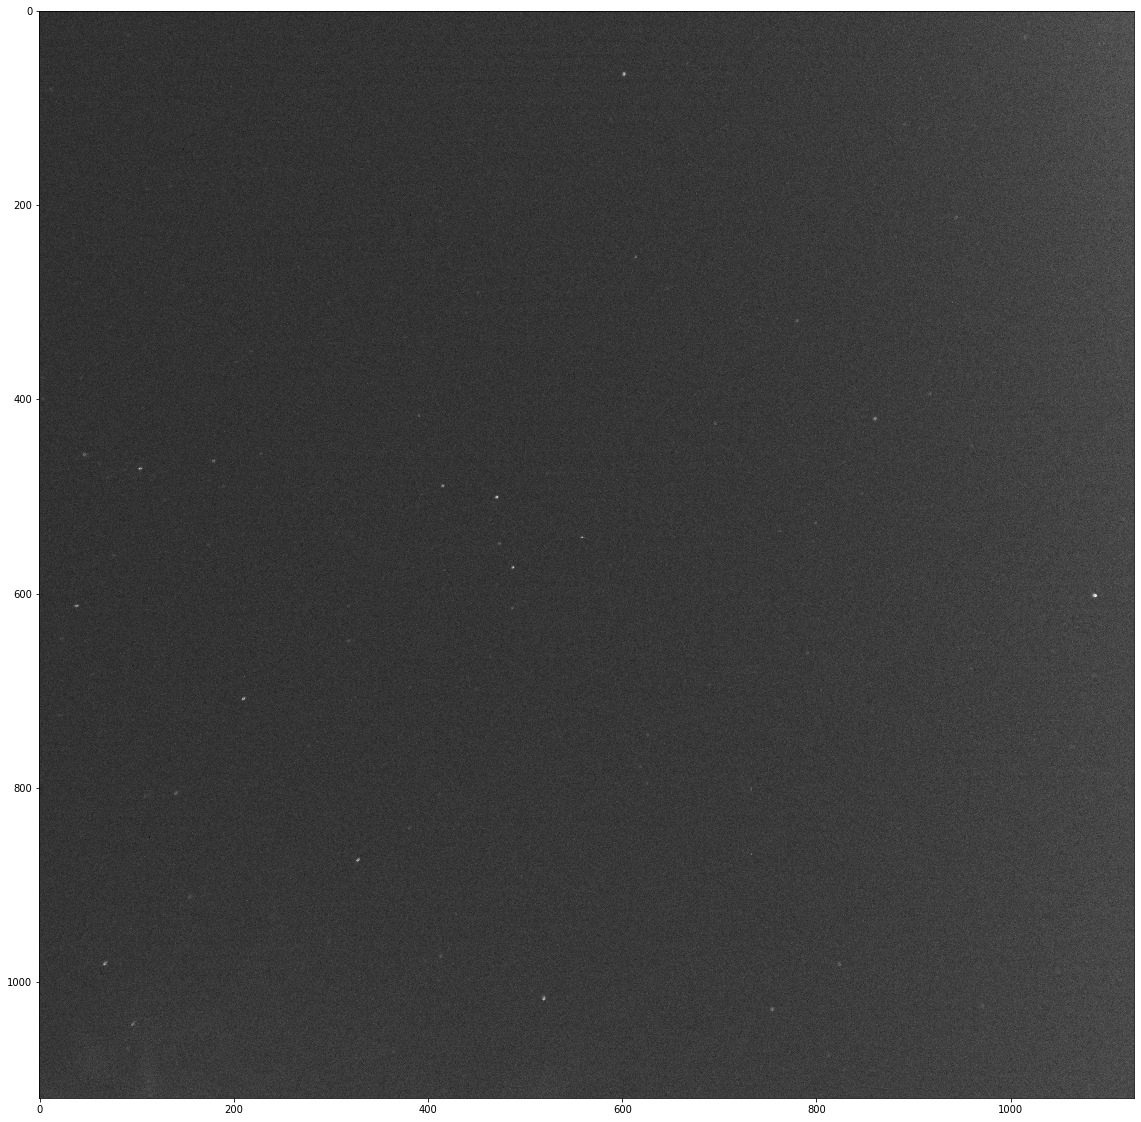

In [2]:
image_folder = "."
file_list = os.listdir(image_folder)
file_list = [os.path.join(image_folder, x) for x in file_list if x.startswith('testa_')]
file_list.sort()
# print(file_list)
stacked_image = sumImages(file_list[:400])
_plot(stacked_image)

Max 1.4450337534692892 min 0.7970658092509649


<AxesSubplot:>

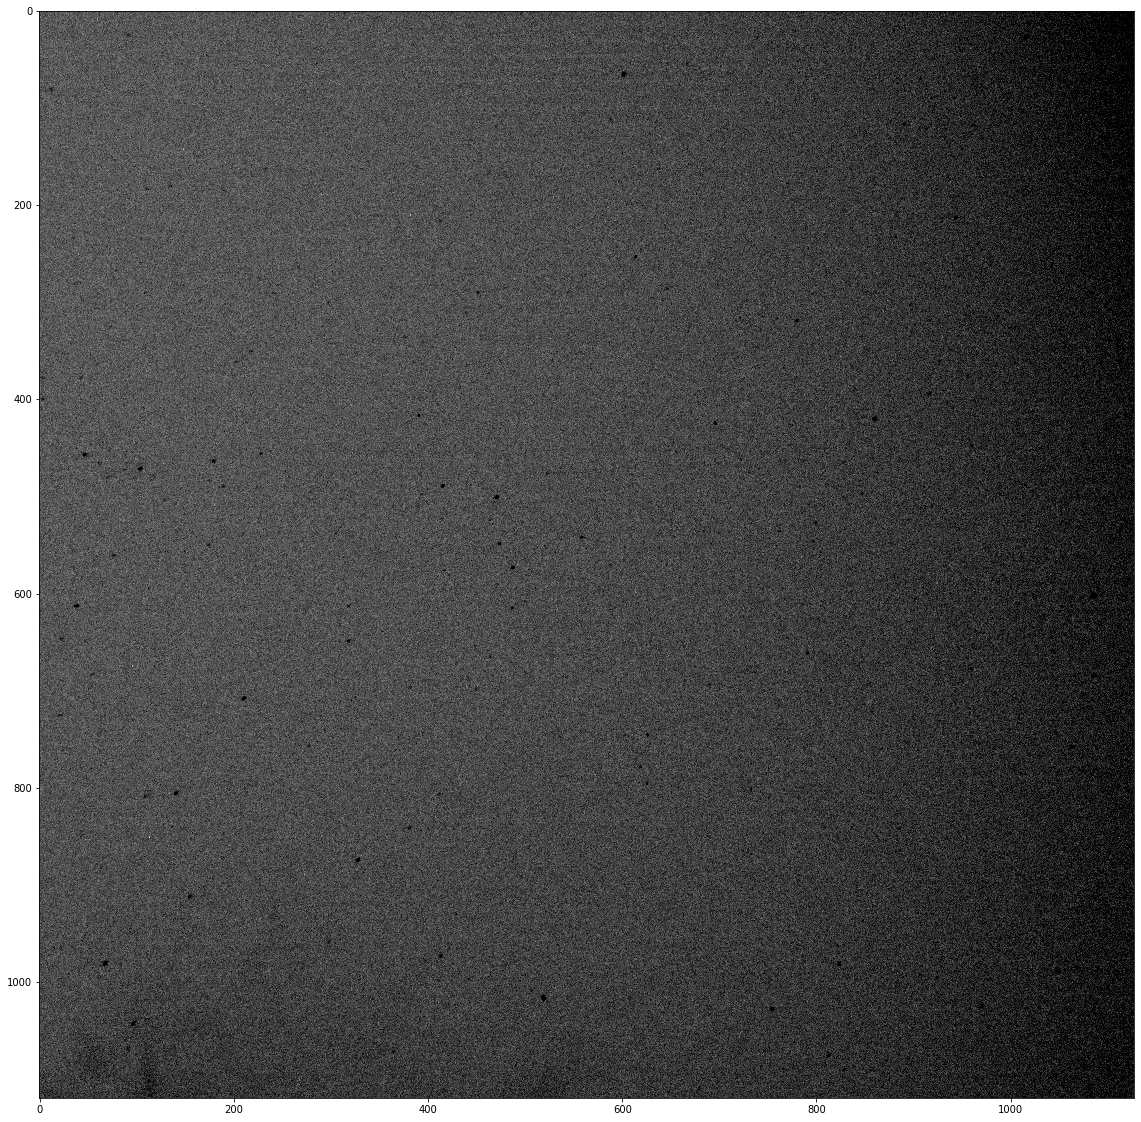

In [3]:
print("Max", np.max(stacked_image),"min", np.min(stacked_image))
stacked = stacked_image - np.min(stacked_image)
stacked /= np.max(stacked)
stacked = (stacked * -1) + 1
_plot(stacked, vmin=0.7)